# Credit Card Fraud Detection (Random Forest + SMOTE)

This notebook follows the pipeline:
1. Data Loading & Basic Checks
2. EDA (Class imbalance, Amount distribution, Correlations)
3. Preprocessing (Scale Time/Amount, Stratified split, SMOTE on training only)
4. Model (Random Forest)
5. Evaluation (5-fold CV F1, test report, Precision-Recall curve / AUPRC)


In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    average_precision_score
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # IMPORTANT: SMOTE inside CV folds

sns.set(style="whitegrid")
RANDOM_STATE = 42


## 1) Data Loading & Basic Checks
Loads `creditcard.csv` from the project root if present; otherwise falls back to `../creditcardfraud/creditcard.csv`.


In [2]:
# Resolve data path
candidates = [
    os.path.join(os.getcwd(), 'creditcard.csv'),
    os.path.join(os.getcwd(), 'creditcardfraud', 'creditcard.csv'),
    os.path.join('..', 'creditcard.csv'),
    os.path.join('..', 'creditcardfraud', 'creditcard.csv'),
]
data_path = None
for p in candidates:
    if os.path.exists(p):
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError(
        'Could not find creditcard.csv. Expected it in the project root or in creditcardfraud/creditcard.csv.'
    )

print('Using data file:', data_path)
df = pd.read_csv(data_path)
print('Shape:', df.shape)
display(df.head())

print('Null values per column:')
display(df.isnull().sum())

print('Class distribution:')
display(df['Class'].value_counts())
display(df['Class'].value_counts(normalize=True).rename('proportion'))


Using data file: ..\creditcardfraud\creditcard.csv
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Null values per column:


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution:


Class
0    284315
1       492
Name: count, dtype: int64

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

## 2) EDA (Exploratory Data Analysis)
### 2.1 Class Distribution (Fraud vs Normal)


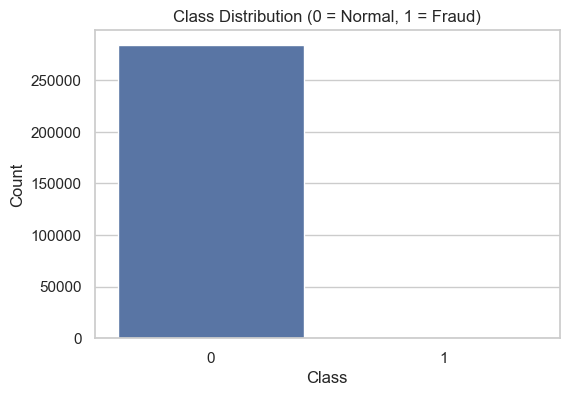

Normal (0): 284,315
Fraud  (1): 492
Imbalance ratio (Normal:Fraud) ≈ 577.9:1


In [3]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Class')
ax.set_title('Class Distribution (0 = Normal, 1 = Fraud)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.show()

counts = df['Class'].value_counts()
normal = int(counts.get(0, 0))
fraud = int(counts.get(1, 0))
print(f'Normal (0): {normal:,}')
print(f'Fraud  (1): {fraud:,}')
print(f'Imbalance ratio (Normal:Fraud) ≈ {normal / max(fraud, 1):.1f}:1')


### 2.2 Distribution of `Amount`


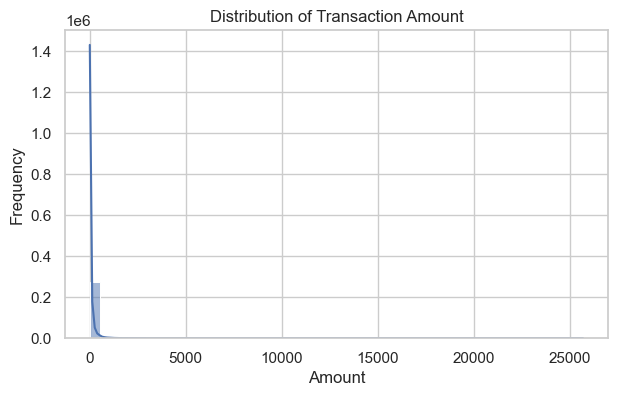

In [4]:
plt.figure(figsize=(7, 4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


### 2.3 Correlation Heatmap
(On this dataset, a full heatmap is large; you can zoom in.)


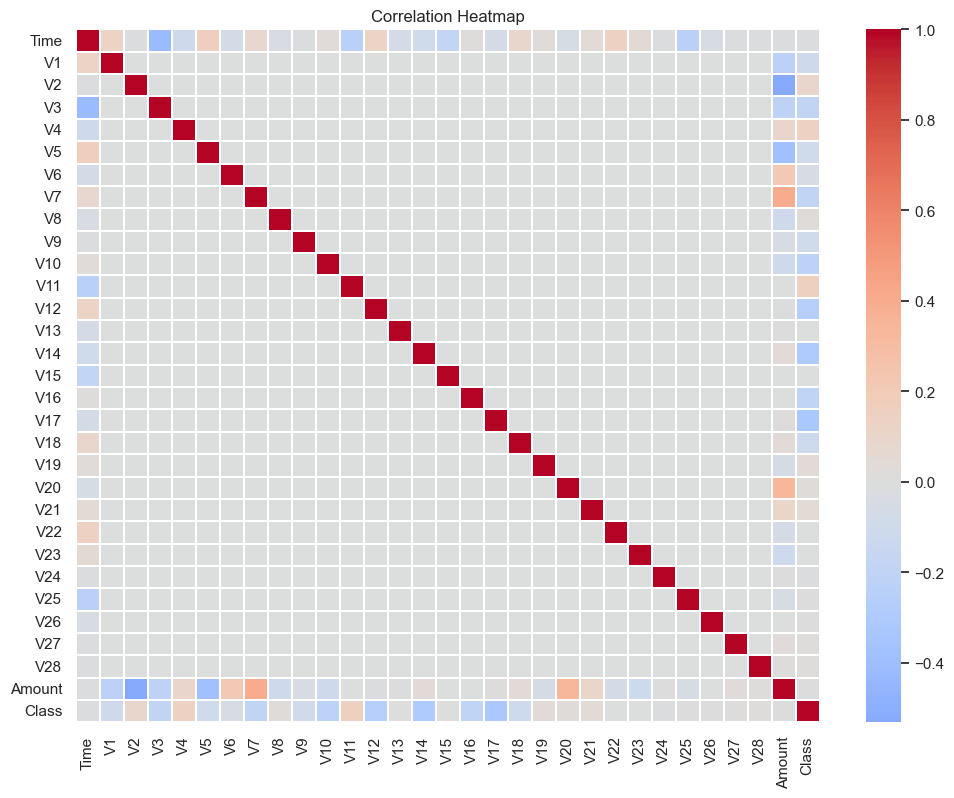

Top correlations with Class:


Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64

Most negative correlations with Class:


V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64

In [5]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.2)
plt.title('Correlation Heatmap')
plt.show()

class_corr = corr['Class'].sort_values(ascending=False)
print('Top correlations with Class:')
display(class_corr.head(10))
print('Most negative correlations with Class:')
display(class_corr.tail(10))


## 3) Preprocessing
- Scale `Amount` and `Time` using `StandardScaler`
- Stratified train/test split
- **Crucial:** Apply SMOTE **only** to the training set (done safely via an `imblearn` Pipeline)


In [6]:
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

scale_cols = ['Time', 'Amount']
other_cols = [c for c in X.columns if c not in scale_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_cols),
        ('passthrough', 'passthrough', other_cols),
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Train fraud rate:', float(y_train.mean()))
print('Test fraud rate :', float(y_test.mean()))


Train shape: (227845, 30) Test shape: (56962, 30)
Train fraud rate: 0.001729245759178389
Test fraud rate : 0.0017204452090867595


## 4) Model Implementation: Random Forest
We use an `imblearn.pipeline.Pipeline` so SMOTE happens **only during `.fit()`** on training data (and inside each CV fold).


In [7]:
smote = SMOTE(random_state=RANDOM_STATE)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('smote', smote),
    ('rf', rf),
])


## 5) Evaluation (Validation)
### 5.1 5-Fold Cross-Validation (Mean F1-score)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_f1_scores = cross_val_score(
    model,
    X_train, y_train,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print('5-Fold CV F1 scores:', cv_f1_scores)
print('Mean CV F1:', float(cv_f1_scores.mean()))
print('Std  CV F1:', float(cv_f1_scores.std()))


### 5.2 Train on Training Set, Evaluate on Test Set


In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

print('\nClassification Report (focus on Class=1 metrics):')
print(classification_report(y_test, y_pred, digits=4))


### 5.3 Precision-Recall Curve (AUPRC)
ROC curves can be misleading for heavily imbalanced datasets, so we focus on Precision-Recall and AUPRC.


In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, y_proba)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, linewidth=2)
plt.title(f'Precision-Recall Curve (AUPRC = {ap:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

print('AUPRC (Average Precision):', float(ap))
